In [12]:
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import plotly.express as px

#Let's define a 2D field, sampled in a grid

delta = 0.025
x = np.arange(-3.0, 3.0, delta)
y = np.arange(-3.0, 3.0, delta)
X, Y = np.meshgrid(x, y)
Z1 = np.exp(-X**2 - Y**2)
Z2 = np.exp(-(X - 1)**2 - (Y - 1)**2)
Z = (Z1 - Z2) * 2


<h3> Image display in Matplotlib </h3>

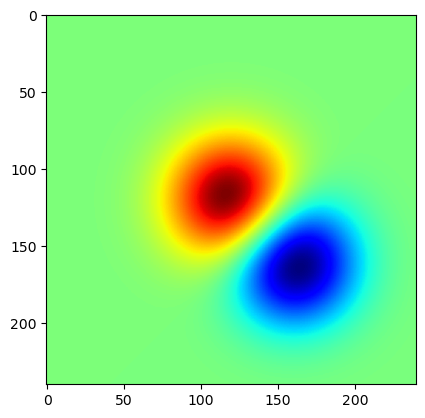

In [13]:
#default colormap for a gridded field is Viridis. Why?
plt.imshow(Z,cmap='jet')

object oriented, with mapping on real world coordinates and interpolation

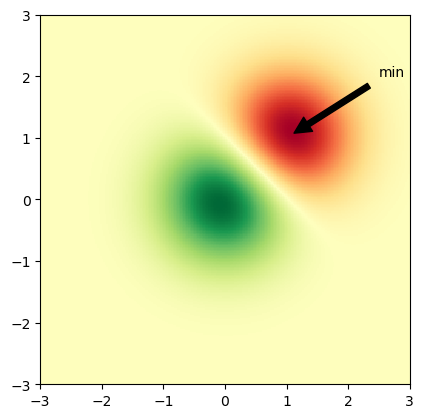

In [22]:
fig, ax = plt.subplots()
#we can specify the range mapped (vmin, vmax), 
# the coordinates corresponding to the grid points (extent)
#the colormap
#the interpolation applied

im = ax.imshow(Z, interpolation='nearest', cmap=cm.RdYlGn,
               origin='lower', extent=[-3, 3, -3, 3],
               vmax=abs(Z).max(), vmin=-abs(Z).max())

#we can add annotations (remember, it is useful)

ax.annotate('min', xy=(1, 1), xytext=(2.5, 2),
             arrowprops=dict(facecolor='black', shrink=0.08),
             )
plt.show()


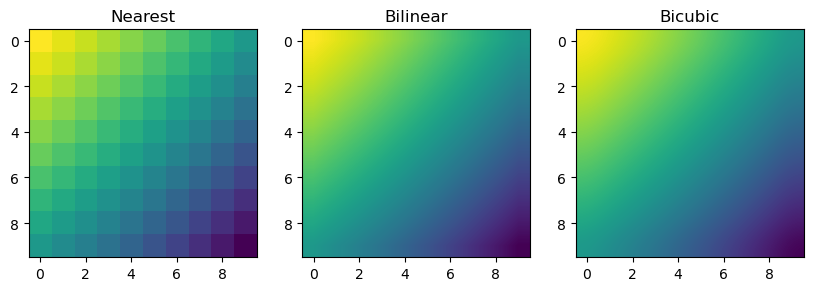

In [ ]:
#small multiple visualization showing zoomed resampled image details
#here we see the effect of different interpolation choices

fig, axs = plt.subplots(1, 3, figsize=(10, 3))
for ax, interp in zip(axs, ['nearest', 'bilinear', 'bicubic']):
    ax.imshow(Z[125:135,125:135], interpolation=interp)
    ax.set_title(interp.capitalize())


plt.show()

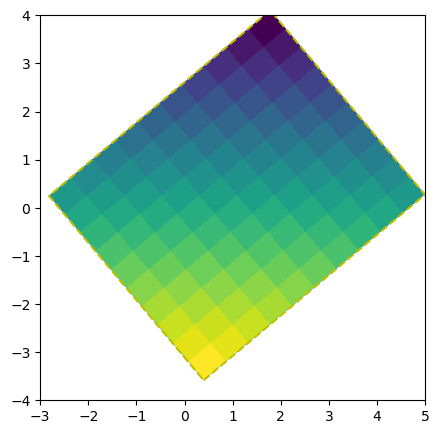

In [27]:
# original grid can be not only scaled with respect to the display grid, 
# but also rotated

import matplotlib.transforms as mtransforms
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
im = ax.imshow(Z[125:135,125:135], interpolation='none',
                   origin='lower',
                   extent=[-2, 4, -3, 2], clip_on=True)

trans_data = mtransforms.Affine2D().rotate_deg(40) + ax.transData
im.set_transform(trans_data)

# display intended extent of the image
# the raster layer can be drawn in a region of the figure 
# (and mixed with other plotted elements)

x1, x2, y1, y2 = im.get_extent()
ax.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], "y--",
            transform=trans_data)
ax.set_xlim(-3, 5)
ax.set_ylim(-4, 4)

plt.show()

* Contouring<br>
we can represent the raster data, with color mapping and superimposed contours in the same visualization

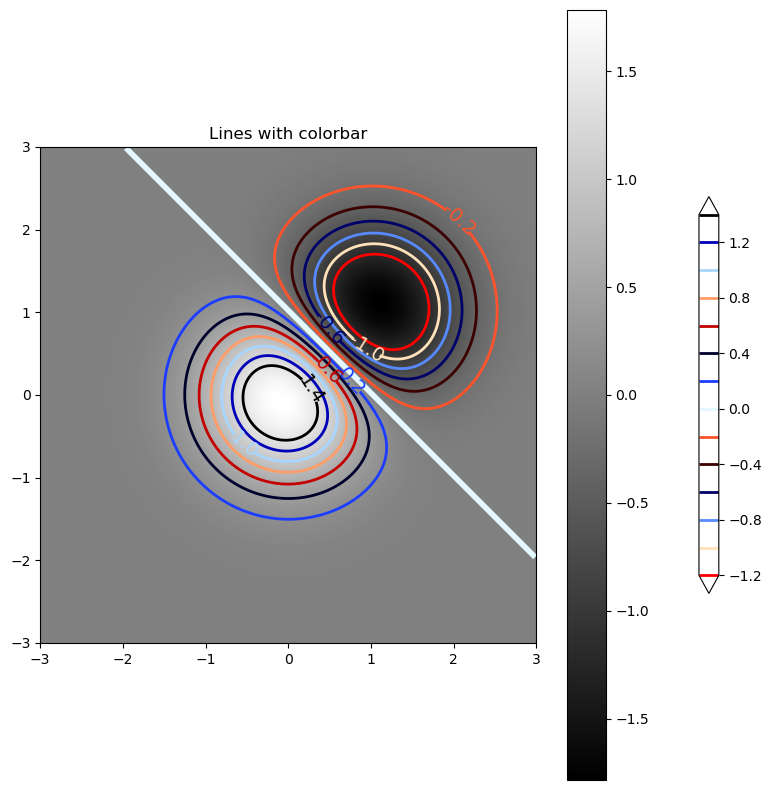

In [34]:
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(Z, interpolation='bilinear', origin='lower',
               cmap=cm.gray, extent=(-3, 3, -3, 3))
levels = np.arange(-1.2, 1.6, 0.2)
CS = ax.contour(Z, levels, origin='lower', cmap='flag', extend='both',
                linewidths=2, extent=(-3, 3, -3,3))

# Thicken the zero contour.
zc = CS.collections[6]
plt.setp(zc, linewidth=4)

ax.clabel(CS, levels[1::2],  # label every second level
          inline=True, fmt='%1.1f', fontsize=14)

# make a colorbar for the contour lines
CB = fig.colorbar(CS, shrink=0.8)

ax.set_title('Lines with colorbar')

# We can still add a colorbar for the image, too.
CBI = fig.colorbar(im)

# This makes the original colorbar look a bit out of place,
# so let's improve its position.

l, b, w, h = ax.get_position().bounds
ll, bb, ww, hh = CB.ax.get_position().bounds
CB.ax.set_position([ll, b + 0.1*h, ww, h*0.8])

plt.show()


A classical field where 2D raster data measuring physical fields 
are captured and need to be visualized is diagnostic imaging
Here the data format is DICOM. Raster images comes with spatial 
coordinates associated to the grid and phisical measurements
PyDicom is a tool for working with DICOM data


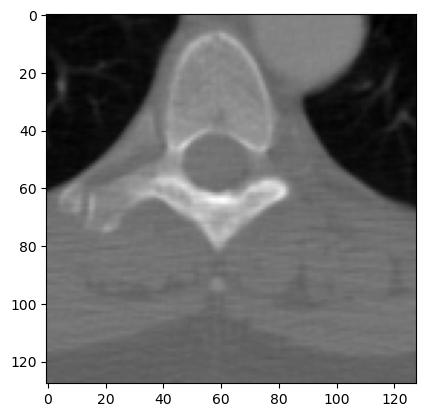

In [37]:
#for medical CT data the colormap used is grayscale, but the mapped range
#is a visualization choice. The selection (corresponding here to the 
# setting of clim=(min max) is called windowing. Try to change it
import pydicom
from pydicom import dcmread
from pydicom.data import get_testdata_file

fpath = get_testdata_file('CT_small.dcm')
ds = dcmread(fpath)
plt.imshow(ds.pixel_array, cmap=plt.cm.gray) #the usual colormap here is grayscale!

In [38]:
# data comes with various metadata
print(f"Patient Name.......: {ds.PatientName}")
print(f"Patient ID.......: {ds.PatientID}")
print(f"Modality.........: {ds.Modality}")
print(f"Study Date.......: {ds.StudyDate}")
print(f"Image size.......: {ds.Rows} x {ds.Columns}")
print(f"Pixel Spacing....: {ds.PixelSpacing}")


Patient Name.......: CompressedSamples^CT1
Patient ID.......: 1CT1
Modality.........: CT
Study Date.......: 20040119
Image size.......: 128 x 128
Pixel Spacing....: [0.661468, 0.661468]


Actually many kinds of medical images are volumetric, as we have 3D grids
But 2D visualization of single slice is used for analysis
Here we load multiple images and we show that data comes with metadata associating physical coordinates to the voxel grid

In [39]:
import os
PathDicom = "AorticCT/"
lstFilesDCM = []  # create an empty list
for dirName, subdirList, fileList in os.walk(PathDicom):
    for filename in fileList:
        if ".dcm" in filename.lower():  # check whether the file's DICOM
            lstFilesDCM.append(os.path.join(dirName,filename))

In [40]:

# Get ref file
RefDs = pydicom.read_file(lstFilesDCM[0])

# Load dimensions based on the number of rows, columns, and slices (along the Z axis)
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(lstFilesDCM))

# Load spacing values (in mm)
ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness))

In [ ]:
print(ConstPixelSpacing)

(0.742188, 0.742188, 2.5)


In [41]:
print(ConstPixelDims)

(512, 512, 29)


In [ ]:
x = np.arange(0.0, (ConstPixelDims[0]+1)*ConstPixelSpacing[0], ConstPixelSpacing[0])
y = np.arange(0.0, (ConstPixelDims[1]+1)*ConstPixelSpacing[1], ConstPixelSpacing[1])
z = np.arange(0.0, (ConstPixelDims[2]+1)*ConstPixelSpacing[2], ConstPixelSpacing[2])

In [ ]:
# The array is sized based on 'ConstPixelDims'
ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

# loop through all the DICOM files
for filenameDCM in lstFilesDCM:
    # read the file
    ds = pydicom.read_file(filenameDCM)
    # store the raw image data
    ArrayDicom[:, :, lstFilesDCM.index(filenameDCM)] = ds.pixel_array  

Datasets also include indications of optimal windowing for visualization. There are specific DICOM fields for this: Rescale Intercept (RI), Window Width (ww), Window Center (wc)

In [ ]:
ds['WindowWidth']

(0028, 1051) Window Width                        DS: '400.0'

In [ ]:
ds['WindowCenter']

(0028, 1050) Window Center                       DS: '80.0'

In [ ]:
ds['RescaleIntercept']

(0028, 1052) Rescale Intercept                   DS: '-1024.0'


The correct windowing of the numerical value is (-RI+wc-ww ,-RI+wc+ww)

In [ ]:
#visualization of full range without correct windowing, of slice 100 pf the dataset
fig = px.imshow(np.flipud(ArrayDicom[:, :, 0]), color_continuous_scale='gray')
fig.show()

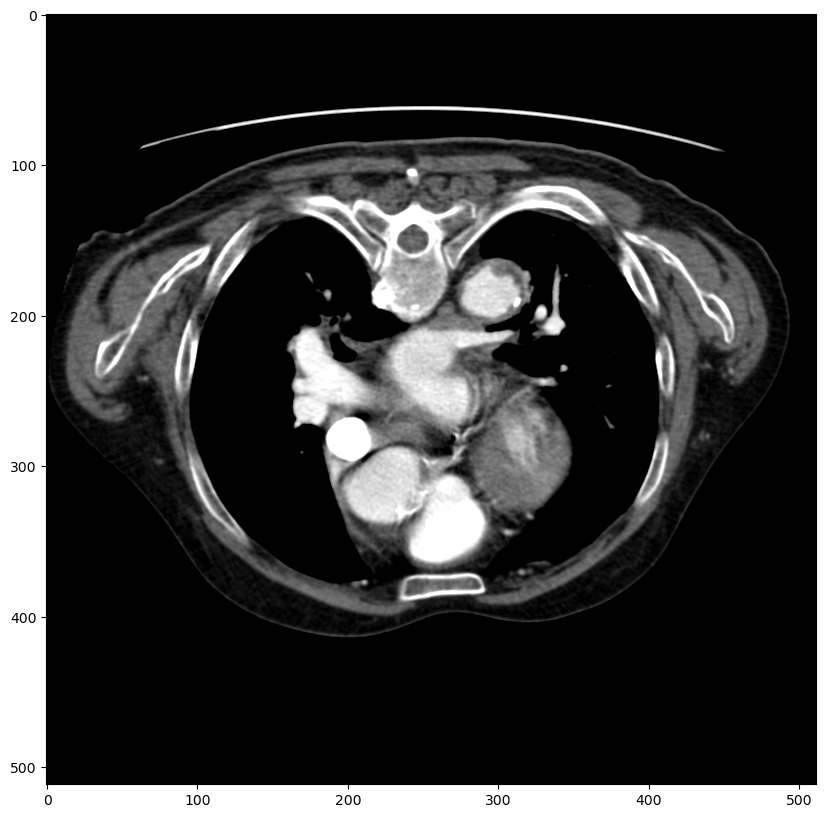

In [ ]:
#with windowing
fig, ax = plt.subplots(1, 1, figsize=(10,10))
plt.set_cmap(plt.gray())
ax.imshow(np.flipud(ArrayDicom[:, :,0]), clim=(1024+80-200,1024+80+200), interpolation='bicubic')


Photos are raster data as well, but here original data encode RGB channels as well

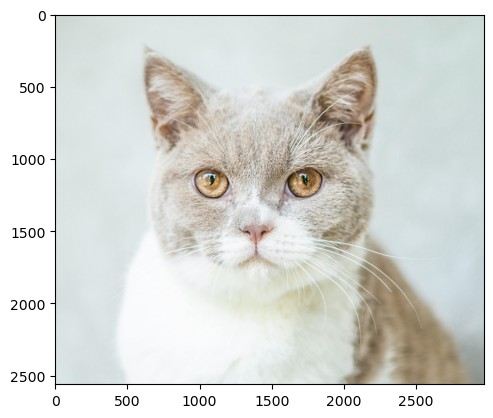

In [ ]:
import matplotlib.image as mpimg
img = mpimg.imread('cat.jpeg')
imgplot = plt.imshow(img)
plt.show()

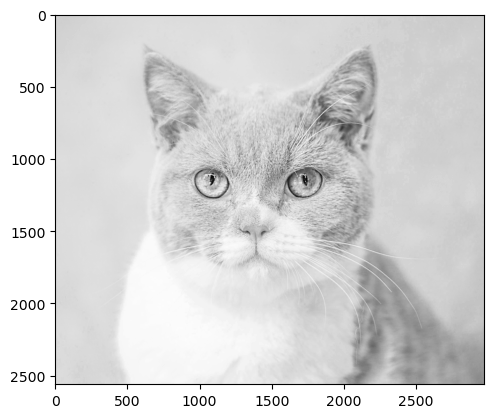

In [ ]:
#original data are WxHx3 and we can select a single color channel
red_img = img[:, :, 0]

# This is array slicing.  You can read more in the `Numpy tutorial
# <https://docs.scipy.org/doc/numpy/user/quickstart.html>`_.
# each channel is a scalar and if we try to show it, 
# a colormap is applied by default
plt.imshow(red_img)
# Here the photo channel is actually visualized as any other 2D raster array, using a colormap. The default is grayscale 

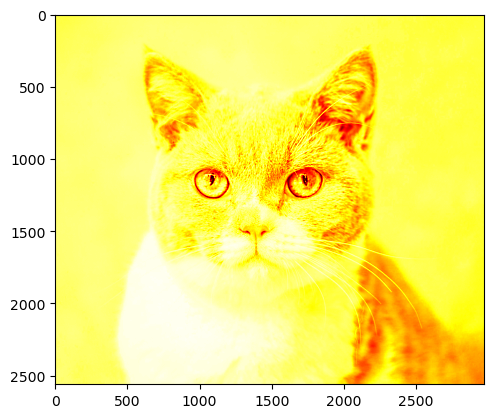

In [ ]:
#But changing the colormap we can change the perception of the value
plt.imshow(red_img, cmap="hot")


For photos is also interesting to do something like the windowing procedure adopted in scientific visualization. In fact to ehnance the contrast we may remap smartly the input range in the visualization range. 
How can we understand how is the input range used? Looking at the histogram showing the occurrence of pixels with data in different intervals!


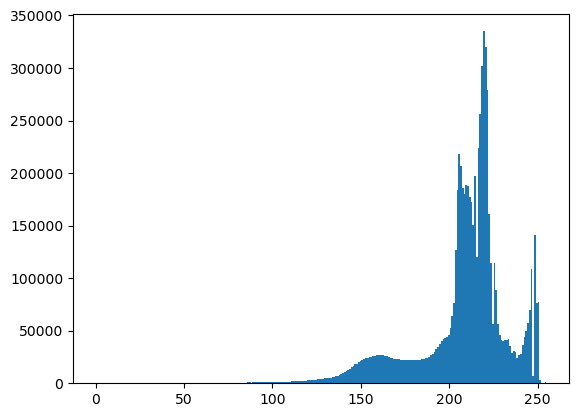

In [ ]:
plt.hist(red_img.ravel(), bins=256);

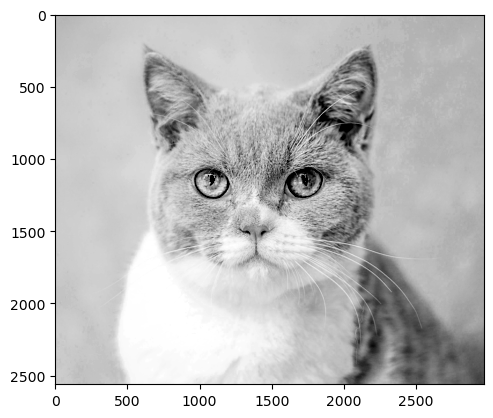

In [ ]:
#the range is not well exploited. we enhance contrast perception

imgplot = plt.imshow(red_img, clim=(100,250))

The fact that we can play with the acquired data and remap the light measurement on the display color is clear when we visualize HDR images
Here the encoded pixel value is the actual measurement of light intensity and can be mapped differently to simulate different photographic exposures and make bright or dark details more evident. This is typically done in the rendering of HDR (high dynamic range) images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


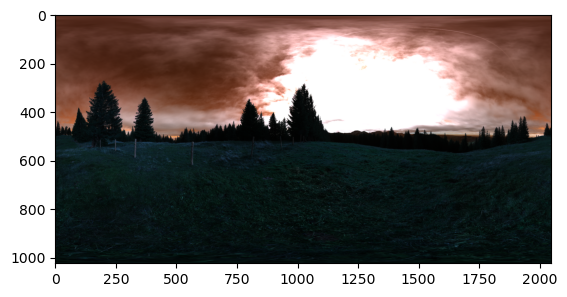

In [ ]:
import cv2
hdr_path = 'immenstadter_horn_2k.hdr'
img = cv2.imread(hdr_path, flags=cv2.IMREAD_ANYDEPTH)
plt.imshow(img);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


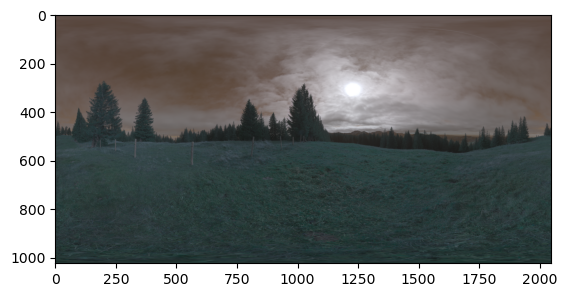

In [ ]:
from skimage import exposure
# gamma and gain parameters are between 0 and 1
adjusted_gamma_image = exposure.adjust_gamma(img, gamma=0.3, gain=0.5)

plt.imshow(adjusted_gamma_image)

